# HLSM Covariate Effect

In [24]:
suppressMessages(library(tmvtnorm))
suppressMessages(library(HLSM))
suppressMessages(library(mvtnorm))
suppressMessages(library(truncnorm))
suppressMessages(library(MCMCpack))
suppressMessages(library(latentnet))

## HLSM Package

In [15]:
ptm <- proc.time()

priors = NULL
tune = NULL
initialVals = NULL
niter = 1000


# Collecting Covariate Matrix Used in the Paper
Cov1 = list()
for (i in 1:15){
    Cov1[[i]] = array(ps.edge.vars.mat[[i]][,,3],dim=c(nrow(ps.edge.vars.mat[[i]][,,3]), 
                                                     nrow(ps.edge.vars.mat[[i]][,,3]),
                                                     1))
}

# Model Fit
random.fit = HLSMrandomEF(Y = ps.advice.mat,FullX = Cov1,
                          initialVals = initialVals, priors = priors,
                          tune = tune,tuneIn = FALSE,dd = 2,niter = niter,
                          intervention = 0)
# Collecting Coefficients
Beta = getBeta(random.fit)
Beta0 = getIntercept(random.fit)

proc.time() - ptm

[1] "Starting Values Set"


   user  system elapsed 
 33.253   0.673  35.608 

## Vanilla MCMC for Covariate Effect

### Model Specification
\begin{align*}
\text{logit}P(Y_{ijk} = 1)&=\beta_{0k} + \beta_{1k}X_{ijk} - |Z_{ik} - Z_{jk}|\\
Z_{ik} &\sim \text{MVN}\Big( 
  \begin{pmatrix} 0 \\ 0 \end{pmatrix},\begin{pmatrix} 10 & 0 \\ 0 & 10 \end{pmatrix}\Big)\\
\beta_{0k} &\sim \text{N}(\mu_0, \sigma_0), k=\{1, \dots, 15\}\\
\beta_{1k} &\sim \text{N}(\mu_1, \sigma_1), k=\{1, \dots, 15\}\\
\mu_0 & \sim \text{N}(0,1),\,\,\, \mu_1 \sim \text{N}(0,1)\\
\sigma_0^2 & \sim \text{IG}(100,150), \,\,\,
\sigma_1^2  \sim \text{IG}(100,150)
\end{align*}

In [34]:
ptm <- proc.time()

# Initial Values
N = 15
MU_z = c(0,0)
COV_z = matrix(c(10,0,0,10), byrow=T, nrow=2)
b0 = rnorm(N,0,1)
b = rnorm(N,0,1)

# Tuned Stepsize. With this step size, the acceptance rate of MH is around 35%
step_z = 5
step_b0 = 0.3
step_b = 1.2

mu0 = mu = 0
s02 = s2 = 1
Y = ps.advice.mat

X = list()
nk = numeric(N)

for (i in 1:N) {
  X[[i]] = ps.edge.vars.mat[[i]][,,3]
  diag(X[[i]]) = NA
  nk[i] = nrow(X[[i]])
}

Z = list()
for (i in 1:N){
  Z[[i]] = rmvnorm(nk[i],MU_z,COV_z)
}

likelihood_k = function(b0,b,X,Y,Z,nk){
  a = b0 + X * b - as.matrix(dist(Z,diag=T,upper=T),nrow=nk)
  return(exp(a*Y) / (1 + exp(a)))
}


#### Number of Iteration ####
niter = 2000


acc_r_z = acc_r_b0t = acc_r_b1t = 0
cz = cb0 = cb1 = 0

ZZ = list()
B0 = B = matrix(nrow=niter,ncol=N)
M0 = M = S0 = S = numeric(niter)

## MCMC
for (iter in 1:niter){
    
    #Updating Z
    for (k in 1:15){
        Z_p = Z[[k]]
        for (i in 1:nk[k]){
            Z_p[i,] = rmvnorm(1, Z[[k]][i,], diag(step_z,2))
            log_rz = (sum(log(likelihood_k(b0[k],b[k],X[[k]],Y[[k]],Z_p,nk[k]))[i,], na.rm=T) + dmvnorm(Z_p[i,], MU_z, COV_z, log = T)) -
               (sum(log(likelihood_k(b0[k],b[k],X[[k]],Y[[k]],Z[[k]],nk[k]))[i,], na.rm = T) + dmvnorm(Z[[k]][i,], MU_z, COV_z, log = T))
            cz = cz + 1
            if (log(runif(1)) < log_rz) {
                Z[[k]][i,] = Z_p[i,]
                acc_r_z = acc_r_z + 1
            }
        }
    }
  
    #Updating betas
    for (k in 1:15){
    
        b0_p = rnorm(1, b0[k], sqrt(step_b0))
        log_rb0 = sum(log(likelihood_k(b0_p, b[k],X[[k]],Y[[k]],Z[[k]],nk[k])), na.rm = T) + dnorm(b0_p, mu0, sqrt(s02), log = T) -
                 (sum(log(likelihood_k(b0[k],b[k],X[[k]],Y[[k]],Z[[k]],nk[k])), na.rm = T) + dnorm(b0[k], mu0, sqrt(s02), log = T))
        cb0 = cb0 + 1
        if( log(runif(1)) < log_rb0 ) {
            b0[k] = b0_p
            acc_r_b0t = acc_r_b0t + 1
        }
        
            b_p = rnorm(1, b[k], sqrt(step_b))
        
            log_rb = sum(log(likelihood_k(b0[k],b_p,X[[k]],Y[[k]],Z[[k]],nk[k])), na.rm = T) + dnorm(b_p, mu, sqrt(s2), log = T) -
                (sum(log(likelihood_k(b0[k],b[k],X[[k]],Y[[k]],Z[[k]],nk[k])), na.rm = T) + dnorm(b[k], mu, sqrt(s2), log = T))
            cb1 = cb1 + 1
        if (log(runif(1)) < log_rb ) {
              b[k] = b_p
              acc_r_b1t = acc_r_b1t + 1
        }
        
    }
  
    #Updating mu, sigma
  for (k in 1:15){
     #Gibbs
     s00 = 1
     mu00 = 0
     s02_n= (1/s00 + (15 / s02))^(-1)
     mu0_n= (mu00 / s00 + sum(b0) / s02) * s02_n
   
     mu0 = rnorm(1, mu0_n, sqrt(s02_n))
     ####
   
     s10 = 1
     mu10 = 0
     s2_n= (1/s10 + (15 / s2))^(-1)
     mu_n= (mu10 / s10 + sum(b) / s2) * s2_n
   
     mu = rnorm(1, mu_n, sqrt(s2_n))
   
     #100,150 Gamma(100,150)
     c = 200
     d = 1.5
   
     nu0_n = c + 15
     ss0_n = 1/nu0_n * (c * d + sum((b0-mu0)^2))
   
     s02 = 1/ rgamma(1, nu0_n/2, nu0_n*ss0_n/2)
   
     #
     nu_n = c + 15
     ss_n = 1/nu_n * (c * d + sum((b-mu)^2))
   
     s2 = 1/ rgamma(1, nu_n/2, nu_n*ss_n/2)
    }
   
  M[iter] = mu
  M0[iter] = mu0
  B[iter,] = b
  B0[iter,] = b0
  S[iter] = s2
  S0[iter] = s02
  ZZ[[iter]] = Z
}

proc.time() - ptm

    user   system  elapsed 
 919.609   74.188 1039.955 

In [11]:
#Collecting Data
paste("Acceptance Rate of Z: ", acc_r_z/cz, collapse="")
paste("Acceptance Rate of b0: ", acc_r_b0t/cb0, collapse="")
paste("Acceptance Rate of b1: ", acc_r_b1t/cb1, collapse="")

burnin=200
thining = 10

M0_b = M0[seq(burnin+1, niter, by=thining)]
M_b = M[seq(burnin+1, niter, by=thining)]
S0_b = S0[seq(burnin+1, niter, by=thining)]
S_b = S[seq(burnin+1, niter, by=thining)]
B_b = B[seq(burnin+1, niter, by=thining),]
B0_b = B0[seq(burnin+1, niter, by=thining),]

[1] "Acceptance Rate of Z:  0.363073903002309"

[1] "Acceptance Rate of b0:  0.3689"

[1] "Acceptance Rate of b1:  0.381933333333333"

### Figure 1

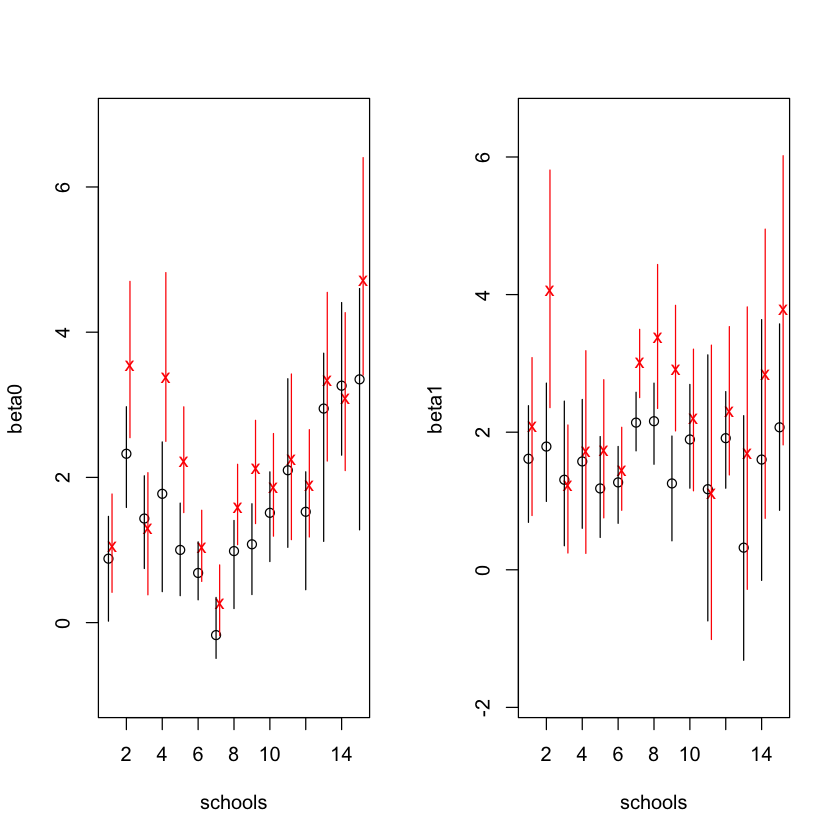

In [12]:
par(mfrow=c(1,2))

b0_ranges = rbind(apply(Beta0,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(B0_b,2,function(x) quantile(x, c(0.025,0.975))))
b0_means = rbind(apply(Beta0,2,mean),
                 apply(B0_b,2,mean))
b0_range1 = b0_ranges[c(1,2),]
b0_range2 = b0_ranges[c(3,4),]

# Figure 1
d = 0.2
plot(b0_means[1,],ylim=c(min(c(b0_range1[1,],b0_range2[1,]))-0.5, max(c(b0_range1[2,],b0_range2[2,]))+0.5),
     ylab='beta0',xlab='schools')
points(seq(1,15)+d,b0_means[2,],col="red",pch='x')
for (k in 1:15){
  segments(k,b0_range1[1,k],k,b0_range1[2,k])
  segments(k+d,b0_range2[1,k],k+d,b0_range2[2,k],col='red')
}

b1_ranges = rbind(apply(Beta,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(B_b,2,function(x) quantile(x, c(0.025,0.975))))
b1_means = rbind(apply(Beta,2,mean),
                 apply(B_b,2,mean))
b1_range1 = b1_ranges[c(1,2),]
b1_range2 = b1_ranges[c(3,4),]

plot(b1_means[1,],ylim=c(min(c(b1_range1[1,],b1_range2[1,]))-0.5, max(c(b1_range1[2,],b1_range2[2,]))+0.5),
     ylab='beta1',xlab='schools')
points(seq(1,15)+d,b1_means[2,],col="red",pch='x')
for (k in 1:15){
  segments(k,b1_range1[1,k],k,b1_range1[2,k])
  segments(k+d,b1_range2[1,k],k+d,b1_range2[2,k],col='red')
}

### Figure 2

In [25]:
ptm <- proc.time()

# Collect Coefficients using 'latentnet' package
b0_LDM = matrix(nrow=4000, ncol=15)
b1_LDM = matrix(nrow=4000, ncol=15)
for (i in 1:15){
  y = (as.network.default(Y[[i]]))
  x = (as.network.default(X[[i]]))
  d.fit<-ergmm(y ~ euclidean(d=2) + edgecov(x))
  b0_LDM[,i] = d.fit$sample$beta[,1]
  b1_LDM[,i] = d.fit$sample$beta[,2]
}

proc.time() - ptm

   user  system elapsed 
257.374   3.016 269.757 

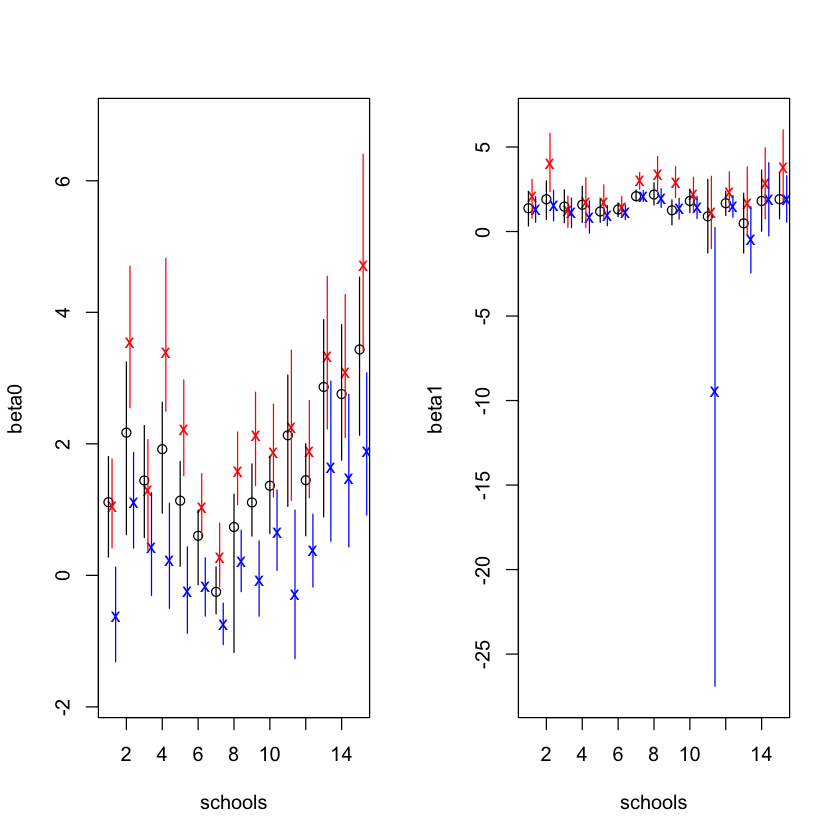

In [33]:
par(mfrow=c(1,2))
b0_ranges = rbind(apply(Beta0,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(B0_b,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(b0_LDM,2,function(x) quantile(x, c(0.025,0.975))))
                  

b0_means = rbind(apply(Beta0,2,mean),
                 apply(B0_b,2,mean),
                 apply(b0_LDM,2,mean))

b0_range1 = b0_ranges[c(1,2),]
b0_range2 = b0_ranges[c(3,4),]
b0_range3 = b0_ranges[c(5,6),]
                      
d = 0.2
plot(b0_means[1,],ylim=c(min(c(b0_range1[1,],b0_range2[1,],b0_range3[1,]))-0.5,
                         max(c(b0_range1[2,],b0_range2[2,],b0_range3[2,]))+0.5),
     ylab='beta0',xlab='schools')
points(seq(1,15)+d,b0_means[2,],col="red",pch='x')
points(seq(1,15)+2*d,b0_means[3,],col="blue",pch='x')

for (k in 1:15){
  segments(k,b0_range1[1,k],k,b0_range1[2,k])
  segments(k+d,b0_range2[1,k],k+d,b0_range2[2,k],col='red')
  segments(k+2*d,b0_range3[1,k],k+2*d,b0_range3[2,k],col='blue')
  
}

b1_ranges = rbind(apply(Beta,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(B_b,2,function(x) quantile(x, c(0.025,0.975))),
                  apply(b1_LDM,2,function(x) quantile(x, c(0.025,0.975))))
b1_means = rbind(apply(Beta,2,mean),
                 apply(B_b,2,mean),
                 apply(b1_LDM,2,mean))
b1_range1 = b1_ranges[c(1,2),]
b1_range2 = b1_ranges[c(3,4),]
b1_range3 = b1_ranges[c(5,6),]

plot(b1_means[1,],ylim=c(min(c(b1_range1[1,],b1_range2[1,],b1_range3[1,]))-0.5,
                         max(c(b1_range1[2,],b1_range2[2,],b1_range3[2,]))+0.5),
     ylab='beta1',xlab='schools')
points(seq(1,15)+d,b1_means[2,],col="red",pch='x')
points(seq(1,15)+2*d,b1_means[3,],col="blue",pch='x')

for (k in 1:15){
  segments(k,b1_range1[1,k],k,b1_range1[2,k])
  segments(k+d,b1_range2[1,k],k+d,b1_range2[2,k],col='red')
  segments(k+2*d,b1_range3[1,k],k+2*d,b1_range3[2,k],col='blue')

}

# HLSM Treatment Effect

\begin{align*}
\text{logit}P(Y_{ijk} = 1)&=\beta_{0} + \beta_{1k}X_{ijk} - |Z_{ik} - Z_{jk}| + \alpha T_k\\
Z_{ik} &\sim \text{MVN}\Big( 
  \begin{pmatrix} 0 \\ 0 \end{pmatrix},\begin{pmatrix} 10 & 0 \\ 0 & 10 \end{pmatrix}\Big), i=\{1,\dots, n_k\}\\
\beta_{0} &\sim \text{N}(0, 10)\\
\beta_{1k} &\sim \text{N}(0, 10), k=\{1, \dots, 15\}\\
\alpha &\sim \text{N}(0,10)
\end{align*}

### Generating Data Set

In [17]:
set.seed(1)
nkt = rep(10,20)

Z0 = list()
p = numeric(20)
Xt = list()
Yt = list()
Tt = sample(c(rep(0,10),rep(1,10)),20)
alpha = 0.5
alpha_k = alpha
for (k in 1:20){
  p[k] = runif(1,0.1,0.30)
  Z0[[k]] = rmvnorm(10,MU_z,COV_z)
  samp = rbinom(45,1,p[k])
  Xt[[k]] = matrix(ncol=10, nrow=10)
  Xt[[k]][lower.tri(Xt[[k]])] = samp
  Xt[[k]] = t(Xt[[k]])
  Xt[[k]][lower.tri(Xt[[k]])] = samp
  logit = 2 + 4 * Xt[[k]] - 
    as.matrix(dist(Z0[[k]], diag = T, upper = T),nrow=10) +
    alpha * Tt[k]
  prob = 1/(1+exp(-logit))
  suppressWarnings({Yt[[k]] = matrix(rbinom(100,1,prob), nrow=10, ncol=10)})
}

### MCMC for Treament Effect

In [18]:
ptm <- proc.time()
#Initial Values
N = 20
MU_z = c(0,0)
COV_z = matrix(c(10,0,0,10), byrow=T, nrow=2)
bt0 = rnorm(1,0,sqrt(10))
bt = rnorm(20,0,sqrt(10))
alpha = 1
step_z = 5
step_b0 = 1.5
step_b = 7
step_alpha = 0.1

likelihood_kt = function(bt0,bt,Xt,Yt,Zt,nkt,Tt,alpha){
  a = bt0 + Xt * bt - 
    as.matrix(dist(Zt,diag=T,upper=T),nrow=nkt) + 
    alpha * Tt
  return(exp(a*Yt) / (1 + exp(a)))
}

acc_r_z = acc_r_b0t = acc_r_bt = acc_r_a = 0
cz = cb0 = cb = ca = 0

#post zi MH
niter = 2000

ZZ0 = list()
Bt0 = numeric(niter)
Bt = matrix(nrow=niter,ncol=N)
A = numeric(niter)
for (iter in 1:niter){
  for (k in 1:20){
    Zt_p = Z0[[k]]
    for (i in 1:nkt[k]){
      Zt_p[i,] = rmvnorm(1, Z0[[k]][i,], diag(step_z,2))
      log_rzt = (sum(log(likelihood_kt(bt0,bt[k],Xt[[k]],Yt[[k]],Zt_p,nkt[k],Tt[k],alpha))[i,], na.rm=T) + dmvnorm(Zt_p[i,], MU_z, COV_z, log = T)) -
        (sum(log(likelihood_kt(bt0,bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha))[i,], na.rm = T) + dmvnorm(Z0[[k]][i,], MU_z, COV_z, log = T))
      cz = cz + 1
      if (log(runif(1)) < log_rzt) {
        Z0[[k]][i,] = Zt_p[i,]
        acc_r_z = acc_r_z + 1
      }
    }
    
  }
  
  bt0_p = rnorm(1, bt0, sqrt(step_b0))
  log_rbt0 = numeric(20)
  for (k in 1:20){
    log_rbt0[k] = sum(log(likelihood_kt(bt0_p, bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha)), na.rm = T) -
      (sum(log(likelihood_kt(bt0,bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha)), na.rm = T))
  }
  cb0 = cb0 + 1
  if( log(runif(1)) < sum(log_rbt0) + dnorm(bt0_p, 0, sqrt(10), log = T) -  dnorm(bt0, 0, sqrt(10), log = T)) {
    bt0 = bt0_p
    acc_r_b0t = acc_r_b0t + 1
    }
  
  for (k in 1:20){
    bt_p = rnorm(1, bt[k], sqrt(step_b))
    
    log_rbt = sum(log(likelihood_kt(bt0,bt_p,Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha)), na.rm = T) + dnorm(bt_p, 0, sqrt(10), log = T) -
      (sum(log(likelihood_kt(bt0,bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha)), na.rm = T) + dnorm(bt[k], 0, sqrt(10), log = T))
    cb = cb + 1
    
    if (log(runif(1)) < log_rbt ) {
      bt[k] = bt_p
      acc_r_bt = acc_r_bt + 1
    }
    
  }
  
  alpha_p = rnorm(1, alpha, sqrt(step_alpha))
  log_ra = numeric(20)
  for (k in 1:20){
    log_ra[k] = sum(log(likelihood_kt(bt0, bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha_p)), na.rm = T) -
      sum(log(likelihood_kt(bt0,bt[k],Xt[[k]],Yt[[k]],Z0[[k]],nkt[k],Tt[k],alpha)), na.rm = T)
  }
  ca = ca + 1
  if (log(runif(1)) < (sum(log_ra) + (dnorm(alpha_p, 0, sqrt(10), log = T) -
                                      dnorm(alpha, 0, sqrt(10), log = T)))) {
    alpha = alpha_p
    acc_r_a = acc_r_a + 1
  }
  
  ZZ0[[iter]] = Z0
  Bt0[iter] = bt0
  Bt[iter,] = bt
  A[iter] = alpha
}
proc.time() - ptm

   user  system elapsed 
306.181   2.900 319.996 

In [19]:
burnin = 500
thinning = 10

A_b = A[seq(burnin+1, niter, by=thining)]

cat("Acceptance Rate of alpha: ",acc_r_a/ ca)

Acceptance Rate of alpha:  0.3995

### Figure 3

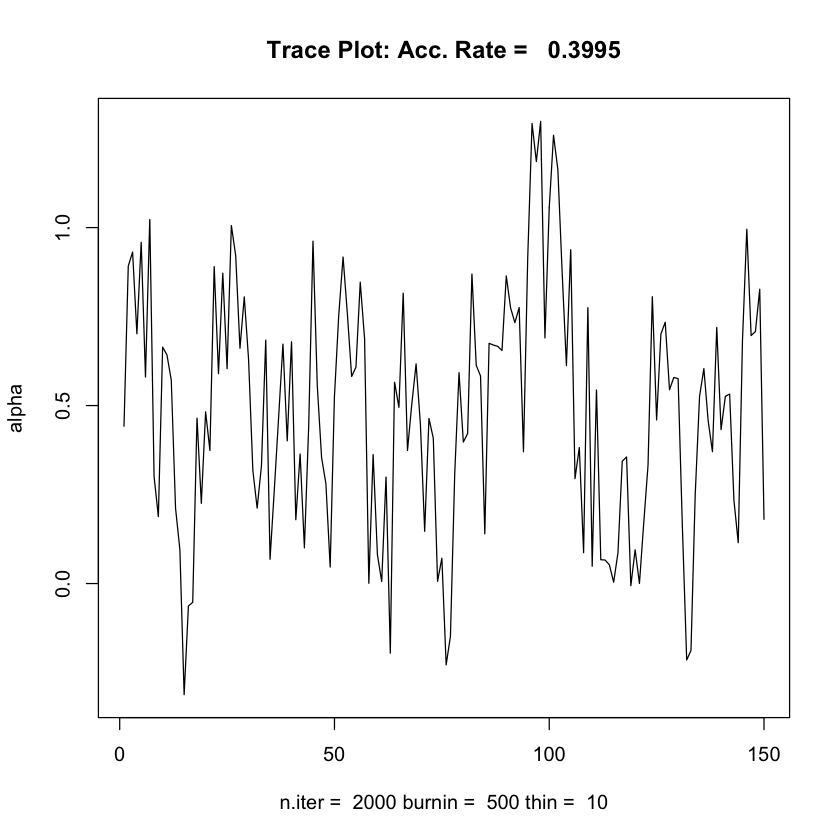

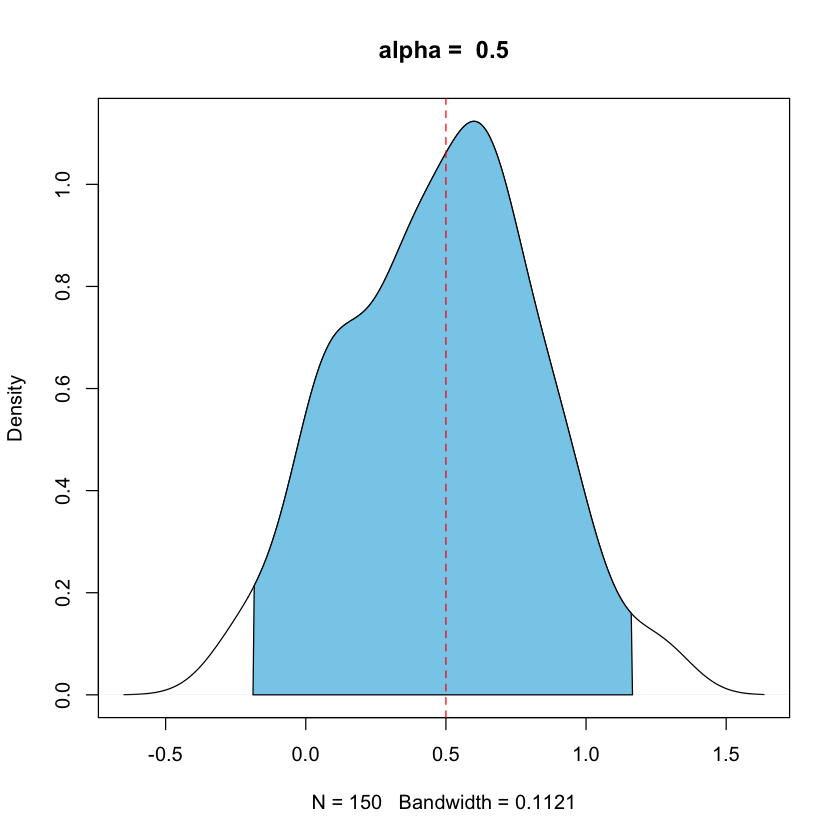

In [20]:
ddd = density(A_b)
qa = quantile(A_b,c(0.025,0.975))

cord.x = ddd$x[which(ddd$x >= qa[1] & ddd$x <= qa[2])]
cord.y = ddd$y[which(ddd$x >= qa[1] & ddd$x <= qa[2])]
cord.y[1] = cord.y[length(cord.y)] = 0

plot(A_b, type='l', main = paste("Trace Plot: Acc. Rate =  ", acc_r_a/ca, collapse = ""),
     ylab = "alpha", xlab = paste("n.iter = ", niter, "burnin = ", burnin, "thin = ", thinning, collapse = ""))

plot(density(A_b),main=paste("alpha = ", alpha_k, collapse = ""))
polygon(cord.x,cord.y,col='skyblue')
abline(v=0.5, lty=2, col='red')